# NB!
This is an example of multi-label text classification.
Fully connected NN is used.
Performed on reuters dataset.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sklearn
import sklearn.preprocessing

from scipy import sparse

import numpy as np
import pandas as pd
import pickle
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from pathlib import Path

import nltk
nltk.download('stopwords')
import nltk.corpus
import nltk.stem.porter
import nltk.stem.lancaster
import nltk.stem.wordnet

# 1. Load data

In [2]:
csv_df = pd.read_csv('reutersCSV.csv', encoding='iso-8859-1', keep_default_na=False)

In [3]:
csv_df.head()

,pid,fileName,purpose,topic.acq,topic.alum,topic.austdlr,topic.austral,topic.barley,topic.bfr,topic.bop,...,topic.tung,topic.tung.oil,topic.veg.oil,topic.wheat,topic.wool,topic.wpi,topic.yen,topic.zinc,doc.title,doc.text
0,1,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...
1,2,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America Inc said ...
2,3,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,TEXAS COMMERCE BANCSHARES &lt;TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas Commerce...
3,4,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,TALKING POINT/BANKAMERICA &lt;BAC> EQUITY OFFER,BankAmerica Corp is not under pressure to act ...
4,5,0,train,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...


# 2. Train/test split

In [4]:
csv_df_train = csv_df[csv_df.purpose == 'train']; csv_df_test = csv_df[csv_df.purpose == 'test']

# 3. Preprocess data

In [5]:
csv_df_train.head()

,pid,fileName,purpose,topic.acq,topic.alum,topic.austdlr,topic.austral,topic.barley,topic.bfr,topic.bop,...,topic.tung,topic.tung.oil,topic.veg.oil,topic.wheat,topic.wool,topic.wpi,topic.yen,topic.zinc,doc.title,doc.text
0,1,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...
1,2,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America Inc said ...
2,3,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,TEXAS COMMERCE BANCSHARES &lt;TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas Commerce...
3,4,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,TALKING POINT/BANKAMERICA &lt;BAC> EQUITY OFFER,BankAmerica Corp is not under pressure to act ...
4,5,0,train,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...


In [6]:
# Let's look what text fields llok like
title, text = csv_df_train.iloc[1][['doc.title', 'doc.text']]
print(title, '\n\n', text)

STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT 

 Standard Oil Co and BP North America Inc said they plan to form a venture to manage the money market borrowing and investment activities of both companies.     BP North America is a subsidiary of British Petroleum Co Plc &lt;BP>, which also owns a 55 pct interest in Standard Oil.     The venture will be called BP/Standard Financial Trading and will be operated by Standard Oil under the oversight of a joint management committee.   Reuter 


### Let's look at labels

In [7]:
label_df_train = csv_df_train.iloc[:,3:-2]

In [8]:
label_df_train.shape, csv_df_train.shape

((14668, 135), (14668, 140))

In [9]:
number_of_documents_per_label = label_df_train.sum()

0 2877


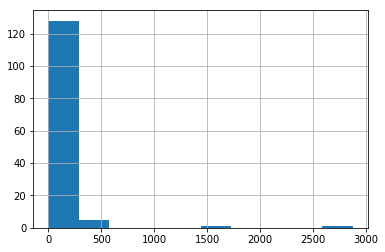

In [10]:
print(number_of_documents_per_label.min(), number_of_documents_per_label.max())
number_of_documents_per_label.hist()

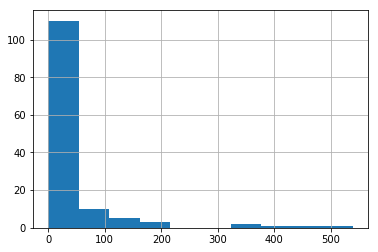

In [11]:
number_of_documents_per_label[number_of_documents_per_label < 1000].hist()

In [12]:
well_represented_topics = number_of_documents_per_label[number_of_documents_per_label > 100].index

In [13]:
well_represented_topics

Index(['topic.acq', 'topic.coffee', 'topic.corn', 'topic.crude', 'topic.dlr',
       'topic.earn', 'topic.gnp', 'topic.grain', 'topic.interest',
       'topic.money.fx', 'topic.money.supply', 'topic.oilseed', 'topic.ship',
       'topic.sugar', 'topic.trade', 'topic.wheat'],
      dtype='object')

### Leave only well represented topics

In [14]:
df_train = csv_df_train[['pid', 'doc.title', 'doc.text'] + well_represented_topics.tolist()]
df_test = csv_df_test[['pid', 'doc.title', 'doc.text'] + well_represented_topics.tolist()]

In [15]:
df_train.iloc[0:1,:]

,pid,doc.title,doc.text,topic.acq,topic.coffee,topic.corn,topic.crude,topic.dlr,topic.earn,topic.gnp,topic.grain,topic.interest,topic.money.fx,topic.money.supply,topic.oilseed,topic.ship,topic.sugar,topic.trade,topic.wheat
0,1,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
df_train.iloc[46:47,:]

,pid,doc.title,doc.text,topic.acq,topic.coffee,topic.corn,topic.crude,topic.dlr,topic.earn,topic.gnp,topic.grain,topic.interest,topic.money.fx,topic.money.supply,topic.oilseed,topic.ship,topic.sugar,topic.trade,topic.wheat
46,47,BRAZIL ANTI-INFLATION PLAN LIMPS TO ANNIVERSARY,"inflation plan, initially hailed at home and a...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### remove rows that contain none of these topics

In [17]:
print('train shape: ', df_train.shape, '; test shape: ', df_test.shape)
df_train.head()

train shape:  (14668, 19) ; test shape:  (6188, 19)


,pid,doc.title,doc.text,topic.acq,topic.coffee,topic.corn,topic.crude,topic.dlr,topic.earn,topic.gnp,topic.grain,topic.interest,topic.money.fx,topic.money.supply,topic.oilseed,topic.ship,topic.sugar,topic.trade,topic.wheat
0,1,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America Inc said ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,TEXAS COMMERCE BANCSHARES &lt;TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas Commerce...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,TALKING POINT/BANKAMERICA &lt;BAC> EQUITY OFFER,BankAmerica Corp is not under pressure to act ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1


In [18]:
df_train = df_train[df_train.iloc[:,3:].any(axis=1)]
df_test = df_test[df_test.iloc[:,3:].any(axis=1)]

In [19]:
print('train shape: ', df_train.shape, '; test shape: ', df_test.shape)
df_train.head()

train shape:  (6957, 19) ; test shape:  (2679, 19)


,pid,doc.title,doc.text,topic.acq,topic.coffee,topic.corn,topic.crude,topic.dlr,topic.earn,topic.gnp,topic.grain,topic.interest,topic.money.fx,topic.money.supply,topic.oilseed,topic.ship,topic.sugar,topic.trade,topic.wheat
4,5,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
5,6,ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS,Argentine grain board figures show crop regist...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
8,9,CHAMPION PRODUCTS &lt;CH> APPROVES STOCK SPLIT,Champion Products Inc said its board of direct...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,10,COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES ...,Computer Terminal Systems Inc said it has comp...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,11,COBANCO INC &lt;CBCO> YEAR NET,"Shr 34 cts vs 1.19 dlrs Net 807,000 vs 2,8...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


# 4. Preprocess text

In [20]:
def lower_case(string):
    return string.lower()

def fix_lt(string):
    # fix the HTML-escaped less-than sign
    return re.sub(r'&lt;', '<', string)

def remove_reuter(string):
    # fix the HTML-escaped less-than sign
    return re.sub(r'reuter$', '', string)

def replace_non_alphanumeric_with_space(string):
    # replace punctuation and different whitespace with space character
    return re.sub(r'[^a-z0-9 ]', ' ', string)

def strip_punctuation(string):
    # remove punctuation
    return re.sub(r'[^a-z0-9\s]', ' ', string)

def remove_stop_words(string, stop_words):
    return ' '.join([ word for word in re.split(' ', string) if not word in stop_words ])

def replace_numeric_with_literal(string):
    return re.sub(r'([0-9]+ ?)+', '<num> ', string)

def compact_whitespace(string):
    return re.sub(r'\s+', ' ', string)

def stem(string, stemmer):
    return ' '.join([ 
        stemmer.stem(word) if hasattr(stemmer, 'stem') else stemmer.lemmatize(word)
        for word in re.split(' ', string) if not word in stop_words 
    ])

In [21]:
stop_words = nltk.corpus.stopwords.words('english')

stemmer = nltk.stem.lancaster.LancasterStemmer()
# stemmer = PorterStemmer()

In [22]:
def pre_process(string):
    s = lower_case(string)
    s = fix_lt(s)
    s = remove_reuter(s)
    s = strip_punctuation(s)
    s = remove_stop_words(s, stop_words)
    s = compact_whitespace(s)
    s = replace_numeric_with_literal(s)
    s = stem(s, stemmer)
    return s.strip()

In [23]:
example = 'Autobahn-FX 2, &lt;RMS> are now being actively developed; GDS decom will be finished by 2055 or 2056'
pre_process(example)

'autobahn fx <num> rms act develop gds decom fin <num>'

In [24]:
def pre_process_text_fields(df):
    df['text'] = df['doc.title'].map(lambda x: pre_process(x)) + ' ' + df['doc.text'].map(lambda x: pre_process(x))
    return df.drop(labels=['doc.title','doc.text'], axis=1)

In [25]:
df_train = pre_process_text_fields(df_train)
df_test = pre_process_text_fields(df_test)

In [26]:
df_train.iloc[0:1,:]

,pid,topic.acq,topic.coffee,topic.corn,topic.crude,topic.dlr,topic.earn,topic.gnp,topic.grain,topic.interest,topic.money.fx,topic.money.supply,topic.oilseed,topic.ship,topic.sugar,topic.trade,topic.wheat,text
4,5,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,nat av pric farm own reserv u agricult depart ...


In [27]:
df_train.shape, df_test.shape

((6957, 18), (2679, 18))

### replace rare words

In [28]:
def get_counts_by_word(docs):
    word_counts = {}
    for doc in docs:
        for word in doc.split():
            if len(word) > 0:
                if word not in word_counts:
                    word_counts[word] = 0
                word_counts[word] += 1
    return word_counts

counts_by_word_pre_processed_train = get_counts_by_word(df_train[['text']].values.ravel().tolist())

len(counts_by_word_pre_processed_train)

14831

In [30]:
counts_by_word_pre_processed_train

{'tue': 1,
 'electricit': 4,
 'turkey': 72,
 'handel': 2,
 'lobby': 18,
 'ptras': 1,
 'surcharg': 5,
 'deilman': 2,
 'yesterday': 453,
 'hair': 4,
 'pac': 306,
 'daiml': 2,
 'bhd': 9,
 'whbf': 1,
 'sthf': 1,
 'jimmy': 1,
 'messel': 1,
 'boxboard': 1,
 'vanguard': 4,
 'himg': 1,
 'gh': 2,
 'biopool': 7,
 'awk': 1,
 'obsc': 4,
 'acquisiton': 3,
 'fif': 20,
 'nobl': 7,
 'touch': 15,
 'outfit': 1,
 'prepart': 1,
 'tadahiko': 1,
 'chimbot': 1,
 'khoo': 3,
 'reign': 2,
 'involunt': 1,
 'budget': 351,
 'scheduled': 142,
 'lefr': 1,
 'capozz': 1,
 'mcdonnell': 6,
 'bankrupt': 4,
 'inlud': 1,
 'maur': 1,
 'koido': 1,
 'emco': 1,
 'oustand': 4,
 'madig': 3,
 'brew': 19,
 'fcr': 2,
 'sheep': 1,
 'macsharry': 1,
 'trod': 1,
 'cypr': 11,
 'fledgl': 3,
 'datacheck': 1,
 'markk': 11,
 'arango': 16,
 'iroquo': 5,
 'scal': 57,
 'silkworm': 15,
 'fellow': 6,
 'misconceiv': 1,
 'lundberg': 2,
 'program': 453,
 'scab': 1,
 'learn': 13,
 'orang': 20,
 'export': 1691,
 'poy': 3,
 'claremont': 8,
 'threw': 1

In [37]:
counts_by_word_pre_processed_train_as_dataframe = pd.DataFrame(pd.Series(counts_by_word_pre_processed_train, name='count')).sort_values('count', ascending=False)

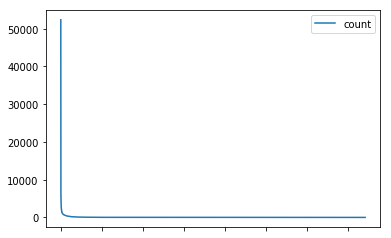

In [39]:
counts_by_word_pre_processed_train_as_dataframe.plot()

In [41]:
num_words = 3000
counts_by_word_pre_processed_train_as_dataframe[:num_words].head(10)

,count
<num>,52365
said,16457
mln,12272
vs,9255
dlrs,8162
reut,6629
pct,5718
year,5716
cts,5609
net,4496


In [42]:
counts_by_word_pre_processed_train_as_dataframe[:num_words].tail()

,count
magnet,12
taiwanes,12
suharto,12
poultry,12
bac,12


In [43]:
top_words = list(counts_by_word_pre_processed_train.items())
top_words.sort(key = lambda it: it[1])
top_words.reverse()
top_words = [ word for word, count in top_words[:num_words] ]
print(len(top_words))
top_words[:10]

3000


['<num>', 'said', 'mln', 'vs', 'dlrs', 'reut', 'pct', 'year', 'cts', 'net']

In [44]:
def replace_rare_words_with_literal(string, top_words):
    return ' '.join([ (word if word in top_words else '<unk>') for word in re.split(' ', string) ])

In [48]:
df_train['text'] = df_train['text'].map(lambda x: replace_rare_words_with_literal(x, top_words))
df_test['text'] = df_test['text'].map(lambda x: replace_rare_words_with_literal(x, top_words))

In [49]:
df_train.head()

,pid,topic.acq,topic.coffee,topic.corn,topic.crude,topic.dlr,topic.earn,topic.gnp,topic.grain,topic.interest,topic.money.fx,topic.money.supply,topic.oilseed,topic.ship,topic.sugar,topic.trade,topic.wheat,text
4,5,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,nat av pric farm own reserv u agricult depart ...
5,6,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,argentin <num> grain oilsee reg argentin grain...
8,9,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,champ produc <unk> approv stock split champ pr...
9,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,comput termin system <unk> complet sal comput ...
10,11,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,<unk> int <unk> year net shr <num> cts vs <num...


# 5. Tokenize text

In [55]:
vocab_size = num_words
 
# define Tokenizer with Vocab Size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df_train.text)
 
x_train = tokenizer.texts_to_matrix(df_train.text, mode='tfidf')
x_test = tokenizer.texts_to_matrix(df_test.text, mode='tfidf')

In [58]:
x_train.shape, x_test.shape

((6957, 3000), (2679, 3000))

In [59]:
df_train.shape, df_test.shape

((6957, 18), (2679, 18))

# 6. Vectorize labels

In [65]:
y_train = df_train.iloc[:,1:-1].values
y_test = df_test.iloc[:,1:-1].values

In [66]:
y_train.shape, y_test.shape

((6957, 16), (2679, 16))

# 7. Train a model

In [72]:
num_labels = y_train.shape[1]

### Try simple fully-connected

In [163]:
model = Sequential()
model.add(Dense(512, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_labels))
model.add(Activation('sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               1536512   
_________________________________________________________________
activation_13 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_14 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                8208      
__________

In [164]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [165]:
history = model.fit(x_train, y_train,
                    batch_size=25,
                    epochs=30,
                    verbose=0,
                    validation_split=0.1)

In [2]:
score = model.evaluate(x_test, y_test, batch_size=100, verbose=0)
 
print('Test accuracy:', score[1])

Test accuracy: 0.9883118700340373
